# Exploring the smoothness and curvature

# Data loading

In [1]:
# primary EDA code
import pandas as pd
import numpy as np
import os

# packages for plots
import matplotlib.pyplot as plt
import seaborn as sns

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for statistics
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# packages for fft
import spectrum
from spectrum import Periodogram, data_cosine

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Data readin
df_gp = pd.DataFrame()
for filename in os.listdir('../data/buy/'):
    if filename.endswith(".txt"): 
        stock = filename[0:4]
        # print("Loading stock data:", stock, ",")
        temp_df = pd.read_csv(os.path.join('../data/buy/', filename), delimiter= '\s+', header = None)
        temp_df.rename(columns={123:'rtn'}, inplace=True)
        temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
        df_gp = pd.concat([df_gp, temp_df])
        continue
    else:
        continue
        
name_gp = df_gp.iloc[21:, 0]
osc_gp = df_gp.iloc[21:, 1:42]
stk_gp = df_gp.iloc[21:, 42:83]
macd_gp = df_gp.iloc[21:, 83:124]
rtn_gp = df_gp.iloc[21:, 124]
label_gp = np.sign(rtn_gp)
label_gp = label_gp.map({1: 1, -1: 0, 0:0})
results_gp = label_gp.map({1: 'EARN', 0: 'LOSS'})

osc_gp2 = round(osc_gp.iloc[:, 0],-1)
osc_gp2 = pd.Series(osc_gp2, name = 'OSC_grp')
osc_mag_to_lbl_analysis_df = pd.concat([name_gp, osc_gp2, label_gp],axis=1)
osc_grp_plot = osc_mag_to_lbl_analysis_df.groupby(['stock','OSC_grp']).mean().reset_index()


# Smoothness calculation

# Method 1

The most general way to measure the smoothness of a curve is `np.var(np.diff(x))`

In [21]:
smooth_diff = []
for i in range(osc_gp.shape[0]):
    smooth_diff.append(np.var(np.diff(osc_gp.iloc[i,:]))/(np.mean(abs(osc_gp.iloc[i,:]))))

# Method 2

In [3]:
smooth_fit = []
list_x = range(41)
for i in range(osc_gp.shape[0]):
    list_y = osc_gp.iloc[i,:]
    poly = np.polyfit(list_x,list_y,5, full = True)
    
    smooth_fit.append(poly[1][0])
    
df_smoo_diff = pd.DataFrame({"smooth": smooth,
                           "rtn": rtn_gp})

# Pre-EDA

Max var 77.4003869375
Min var 9.749999999999998e-06


Text(0.5,1,'Oscillator 3-Day Time Series with smaller smoothness')

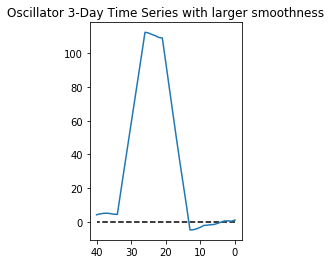

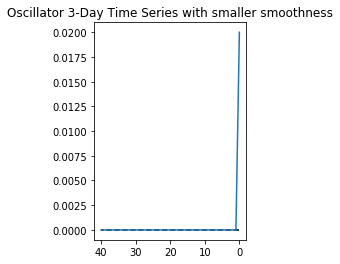

In [5]:
# find the index for max and min smoothness
index_max = np.argmax(smooth)
print("Max var", smooth[index_max])
index_min = np.argmin(smooth)
print("Min var", smooth[index_min])

fig = plt.figure()
layout = (1, 2)
osc_ax_max = plt.subplot2grid(layout, (0, 0))
osc_ax_max.plot(range(41), osc_gp.iloc[index_max,:])
osc_ax_max.invert_xaxis()
plt.hlines(0, xmin=0, xmax=40, colors='k',linestyles = "dashed")
osc_ax_max.set_title('Oscillator 3-Day Time Series with larger smoothness')

fig = plt.figure()
layout = (1, 2)
osc_ax_min = plt.subplot2grid(layout, (0, 1))
osc_ax_min.plot(range(41), osc_gp.iloc[index_min,:])
osc_ax_min.invert_xaxis()
plt.hlines(0, xmin=0, xmax=40, colors='k',linestyles = "dashed")
osc_ax_min.set_title('Oscillator 3-Day Time Series with smaller smoothness')



# Smoothness EDA

Because the variation in the osc values, we clean the dataset to limit the osc values from -5 to 5 for future plot.

In [6]:
osc_gp_sub = osc_gp
rec_index = []
for i in range(osc_gp.shape[0]):
    if (sum(osc_gp.iloc[i,:] > 5) + sum(osc_gp.iloc[i,:] < -5)) > 0:
        rec_index.append(i)
osc_gp_sub = osc_gp_sub.drop(osc_gp_sub.index[rec_index])

In [7]:
osc_gp_sub.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
62,-0.46,-0.56,-0.45,-0.38,-0.42,-0.67,-0.73,-0.75,-0.78,-0.94,...,-0.46,-0.32,-0.12,0.28,0.99,1.59,1.55,1.41,1.30,1.08
63,0.80,0.76,0.86,0.76,0.59,0.48,0.44,0.25,-0.15,-0.46,...,-1.89,-2.14,-1.94,-1.78,-1.69,-1.39,-1.20,-1.02,-0.93,-0.46
123,-2.09,-2.11,-2.09,-1.91,-1.52,-1.03,-0.58,-0.10,0.48,0.98,...,-1.59,-1.61,-1.48,-1.26,-0.99,-0.88,-0.74,-0.51,-0.30,-0.03
124,-3.38,-3.43,-3.19,-2.77,-2.06,-1.36,-0.96,-0.40,0.06,0.61,...,-2.09,-2.11,-2.09,-1.91,-1.52,-1.03,-0.58,-0.10,0.48,0.98
125,-3.11,-3.40,-3.38,-3.43,-3.19,-2.77,-2.06,-1.36,-0.96,-0.40,...,-1.72,-1.90,-2.09,-2.11,-2.09,-1.91,-1.52,-1.03,-0.58,-0.10


In [8]:
osc_gp_cleaned = osc_gp_sub.reset_index(drop = True)

In [9]:
osc_gp_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,-0.46,-0.56,-0.45,-0.38,-0.42,-0.67,-0.73,-0.75,-0.78,-0.94,...,-0.46,-0.32,-0.12,0.28,0.99,1.59,1.55,1.41,1.30,1.08
1,0.80,0.76,0.86,0.76,0.59,0.48,0.44,0.25,-0.15,-0.46,...,-1.89,-2.14,-1.94,-1.78,-1.69,-1.39,-1.20,-1.02,-0.93,-0.46
2,-2.09,-2.11,-2.09,-1.91,-1.52,-1.03,-0.58,-0.10,0.48,0.98,...,-1.59,-1.61,-1.48,-1.26,-0.99,-0.88,-0.74,-0.51,-0.30,-0.03
3,-3.38,-3.43,-3.19,-2.77,-2.06,-1.36,-0.96,-0.40,0.06,0.61,...,-2.09,-2.11,-2.09,-1.91,-1.52,-1.03,-0.58,-0.10,0.48,0.98
4,-3.11,-3.40,-3.38,-3.43,-3.19,-2.77,-2.06,-1.36,-0.96,-0.40,...,-1.72,-1.90,-2.09,-2.11,-2.09,-1.91,-1.52,-1.03,-0.58,-0.10


recalculate the smoothness list based on diff or fit

In [22]:
smooth_cleaned_diff = []
for i in range(osc_gp_cleaned.shape[0]):
    smooth_cleaned_diff.append(np.var(np.diff(osc_gp_cleaned.iloc[i,:]))/(np.mean(abs(osc_gp_cleaned.iloc[i,:]))))
    
    
smooth_cleaned_fit = []
list_x = range(41)
for i in range(osc_gp_cleaned.shape[0]):
    list_y = osc_gp_cleaned.iloc[i,:]
    poly = np.polyfit(list_x,list_y,5, full = True)
    
    smooth_cleaned_fit.append(poly[1][0])
    

In [23]:
def smoothness_plot(smooth,smoothness_interest, sigma):
    
    rec = []
    for value in smoothness_interest:
        temp = 0
        for i in range(len(smooth)):
             
            if (abs(smooth[i] - value) < sigma) & (temp == 0):
                temp = i
            
        rec.append(temp)
    
    with plt.style.context(style = 'bmh'):
        fig = plt.figure()
        layout = (1, 1)
        osc_ax = plt.subplot2grid(layout, (0, 0))
        for i in rec:
            osc_ax.plot(range(41), osc_gp_cleaned.iloc[i,:])
        osc_ax_min.invert_xaxis()
        plt.hlines(0, xmin=0, xmax=40, colors='k',linestyles = "dashed")
        #plt.legend()
        plt.legend(smoothness_interest, title = "Smoothness",loc = 'bottom right')
        plt.xlabel("three days ---> signal")
        plt.ylabel("OSC values")
    return rec
    
    
    
    
   

[0, 15902, 1709, 6]

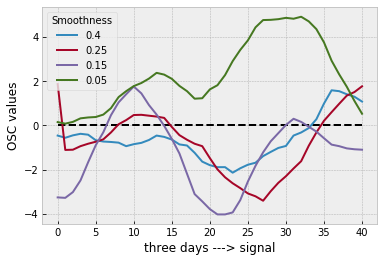

In [26]:
smoothness_plot(smooth_cleaned_diff,[0.4,0.25,0.15,0.05], sigma = 0.01)

[5, 1509, 3964, 1709]

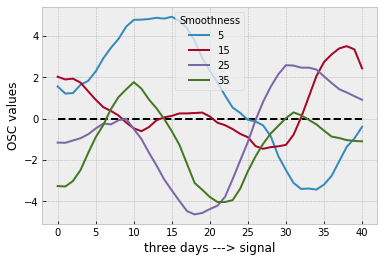

In [20]:
smoothness_plot(smooth_cleaned_fit,[5,15,25,35], sigma = 2)

I personally don't like method 2, see 35 above doesn't really reflect the true condition. 

# Smoothness calculation method 2

In [167]:
para = np.polyfit(range(41), osc_gp_cleaned.iloc[4183,:], 5, full=True)

In [201]:
para[1][0]

4.8581990682175284

In [256]:
def fit_plot(index):
    
    list_x = range(41)
    list_y = osc_gp_cleaned.iloc[index,:]
    with plt.style.context(style = 'bmh'):
        plt.figure()
        poly = np.polyfit(list_x,list_y,5)
        poly_y = np.poly1d(poly)(list_x)
        plt.plot(list_x,poly_y)
        plt.plot(list_x,list_y)
        plt.xlabel("three days ---> signal")
        plt.ylabel("OSC values")
        plt.title("smoothness = 45")
        plt.show()

In [230]:
list_x = range(41)

smooth = []
for i in range(osc_gp_cleaned.shape[0]):
    list_y = osc_gp_cleaned.iloc[i,:]
    poly = np.polyfit(list_x,list_y,5, full = True)
    
    smooth.append(poly[1][0])


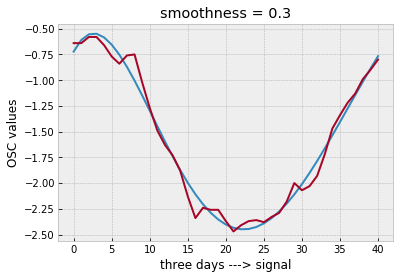

In [200]:
fit_plot(1662)

[5, 1509, 3964, 0]

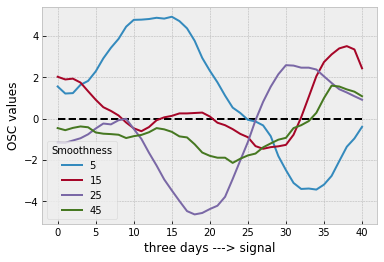

In [244]:
smoothness_plot([5,15,25,45], sigma = 1)

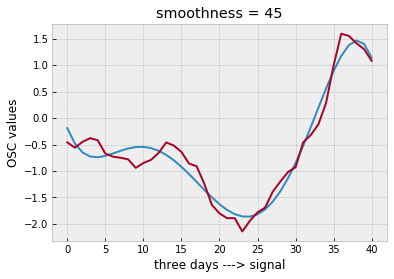

In [257]:
fit_plot(0)

# Explore the relationship between smoothness and return

# Smoothness Method 1

In [27]:
#plt.scatter(smooth, rtn_gp)
df_smoo_rtn = pd.DataFrame({"smooth": smooth_diff,
                           "rtn": rtn_gp})

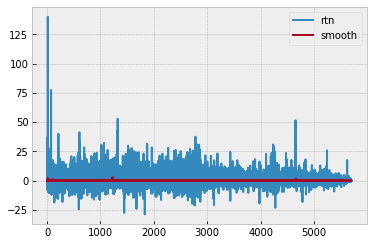

In [28]:
with plt.style.context(style = 'bmh'):
    df_smoo_rtn.plot()

As we can observe from the plot above, there are some interesting points, on which the behaviour of the return value agrees with the smoothness.

We can then take a deeper look for this relationship.

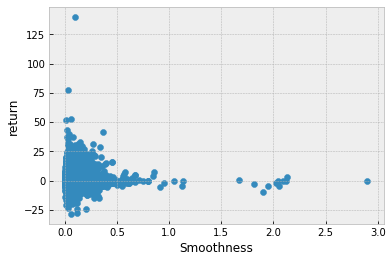

In [30]:
with plt.style.context(style = 'bmh'):
    plt.scatter(df_smoo_rtn["smooth"], df_smoo_rtn["rtn"])
    # plt.hlines(0, xmin=0, xmax = 50, colors='k',linestyles = "dashed")
    plt.xlabel("Smoothness")
    plt.ylabel("return")

Most of the points are gethered around smoothness lower than 1, we can then zoom in that area.

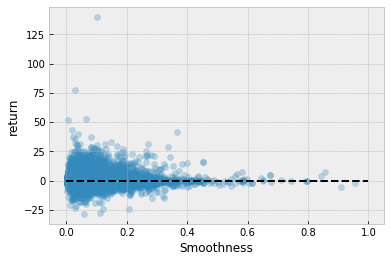

In [31]:
df_smoo_rtn_zoomin = df_smoo_rtn[df_smoo_rtn["smooth"]<1]

with plt.style.context(style = 'bmh'):
    plt.scatter(df_smoo_rtn_zoomin["smooth"], df_smoo_rtn_zoomin["rtn"],alpha=0.3, marker="o")
    plt.hlines(0, xmin=0, xmax=1, colors='k',linestyles = "dashed")
    plt.xlabel("Smoothness")
    plt.ylabel("return")

# Smoothness method 2

In [202]:
smooth = []
list_x = range(41)
for i in range(osc_gp.shape[0]):
    list_y = osc_gp.iloc[i,:]
    poly = np.polyfit(list_x,list_y,5, full = True)
    
    smooth.append(poly[1][0])
    
df_smoo_rtn = pd.DataFrame({"smooth": smooth,
                           "rtn": rtn_gp})

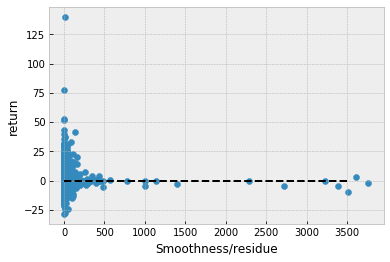

In [205]:
with plt.style.context(style = 'bmh'):
    plt.scatter(df_smoo_rtn["smooth"], df_smoo_rtn["rtn"])
    plt.hlines(0, xmin=0, xmax = 3500, colors='k',linestyles = "dashed")
    plt.xlabel("Smoothness/residue")
    plt.ylabel("return")

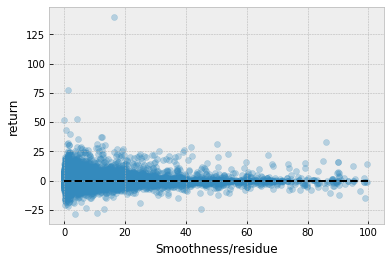

In [206]:
df_smoo_rtn_zoomin = df_smoo_rtn[df_smoo_rtn["smooth"]<100]

with plt.style.context(style = 'bmh'):
    plt.scatter(df_smoo_rtn_zoomin["smooth"], df_smoo_rtn_zoomin["rtn"],alpha=0.3, marker="o")
    plt.hlines(0, xmin=0, xmax=100, colors='k',linestyles = "dashed")
    plt.xlabel("Smoothness/residue")
    plt.ylabel("return")

# Explore the relationship between smoothness and label

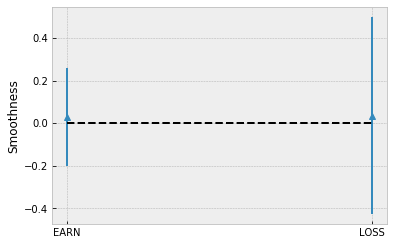

In [134]:
df_smoo_lab = pd.DataFrame({"smooth": smooth,
                           "label": results_gp})

df_smoo_mean = df_smoo_lab.groupby("label").mean().reset_index()
df_smoo_std = df_smoo_lab.groupby("label").std().reset_index()
#    
#        fig = plt.figure(figsize=(10, 7))
#        layout = (1, 1)
#        ax = plt.subplot2grid(layout, (0, 0))
df_results = pd.merge(df_smoo_mean, df_smoo_std,
                       how='left', on=["label"])
# df_results
with plt.style.context('bmh'):
    plt.errorbar(df_results["label"], df_results["smooth_x"], df_results["smooth_y"], linestyle='None', marker='^')
    plt.hlines(0, xmin="EARN", xmax = "LOSS", colors='k',linestyles = "dashed")
    plt.ylabel("Smoothness")

As we can observe, for the curve that returns loss, the variation of the smoothness is bigger. 

# Curvature Calculation
